In [1]:
import h5py
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from preprocessor import get_dataset, get_and_process_data, generate_data, decoding, load_and_process_example
from qwen import load_qwen

/home/ljf1/dis/lora/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model, tokenizer = load_qwen()

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [3]:
file_path = 'lotka_volterra_data.h5'

In [14]:
example_tokenized_data, example_preprocessed_data, example_data, example_times = get_and_process_data(file_path, tokenizer, system_id=700, points=2, alpha=5, decimals=3)
print("Example prey values:", np.array(example_data[:,0]), example_data[:,2])
print("Example predator values:", np.array(example_data[:,1]), example_data[:,3])
print("Preprocessed data:", example_preprocessed_data)
print("Tokenized results:", example_tokenized_data["input_ids"].tolist()[0])

Example prey values: [1.1335121  0.55542254] [2.267 1.111]
Example predator values: [1.1031258 1.2579137] [2.206 2.516]
Preprocessed data: 2.267,2.206;1.111,2.516
Tokenized results: [17, 13, 17, 21, 22, 11, 17, 13, 17, 15, 21, 26, 16, 13, 16, 16, 16, 11, 17, 13, 20, 16, 21]


In [8]:
np.random.seed(441)
example_tokenized_data, example_preprocessed_data, example_data, example_times = load_and_process_example(file_path, tokenizer, points=3, alpha=5, decimals=3, seed=441)
print("Example prey values:", np.array(example_data[:,0][:3]), example_data[:,2][:3])
print("Example predator values:", np.array(example_data[:,1][:3]), example_data[:,3][:3])
print("Preprocessed data:", example_preprocessed_data)
print("Tokenized results:", example_tokenized_data.input_ids[0].tolist())

np.random.seed(441)
full_tokenized_data, full_preprocessed_data, full_data, full_times = load_and_process_example(file_path, tokenizer, points=100, alpha=5, decimals=3, seed=441)
max_token_length = max(full_tokenized_data["input_ids"].shape[1]+1, 1200)
actual_prey = full_data[:,2]
actual_predator = full_data[:,3]
np.random.seed(441)
part_tokenized_data, part_preprocessed_data, part_data, part_times = load_and_process_example(file_path, tokenizer, points=80, alpha=5, decimals=3, seed=441)
model.eval()
with torch.no_grad():
    output = model.generate(part_tokenized_data["input_ids"], attention_mask = part_tokenized_data["attention_mask"], max_new_tokens=max_token_length)
prediction = tokenizer.decode(output[0], skip_special_tokens=True)
pred_prey, pred_predator = decoding(prediction)

Example prey values: [0.8521567 0.6482769 0.5045464] [1.704 1.297 1.009]
Example predator values: [0.9479834  0.94272685 0.87405926] [1.896 1.885 1.748]
Preprocessed data: 1.704,1.896;1.297,1.885;1.009,1.748
Tokenized results: [16, 13, 22, 15, 19, 11, 16, 13, 23, 24, 21, 26, 16, 13, 17, 24, 22, 11, 16, 13, 23, 23, 20, 26, 16, 13, 15, 15, 24, 11, 16, 13, 22, 19, 23]


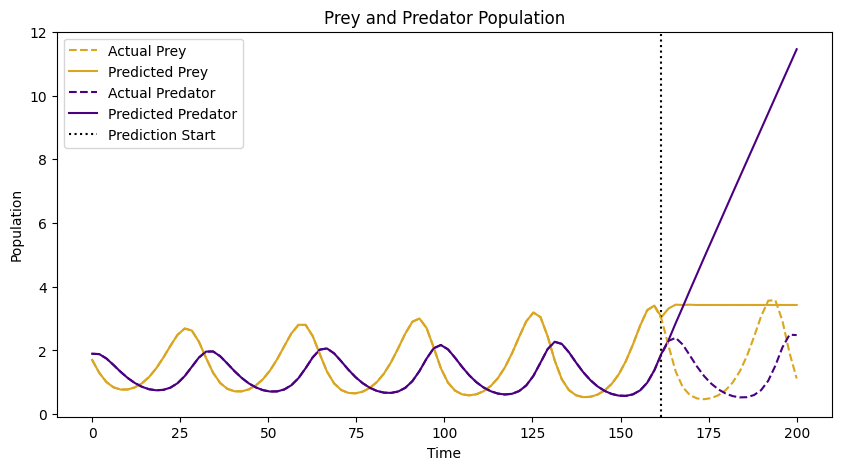

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f"Prey and Predator Population")
ax.plot(full_times, actual_prey, label="Actual Prey", linestyle="--", zorder=100, color="goldenrod")
ax.plot(full_times, pred_prey, label="Predicted Prey", color="goldenrod")
ax.plot(full_times, actual_predator, label="Actual Predator", linestyle="--", zorder=100, color="indigo")
ax.plot(full_times, pred_predator, label="Predicted Predator", color="indigo")
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.axvline(full_times[80], color="black", linestyle="dotted", label="Prediction Start")
ax.legend()
plt.savefig(f"../plots/predictions_example.png", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
print("MEAN PREY SQUARED ERROR:", mean_squared_error(pred_prey, actual_prey))
print("MEAN PREY ABSOLUTE ERROR:", mean_absolute_error(pred_prey, actual_prey))
print("R2 PREY SCORE:", r2_score(pred_prey, actual_prey))
print("MEAN PREDATOR SQUARED ERROR:", mean_squared_error(pred_predator, actual_predator))
print("MEAN PREDATOR ABSOLUTE ERROR:", mean_absolute_error(pred_predator, actual_predator))
print("R2 PREDATOR SCORE:", r2_score(pred_predator, actual_predator))

MEAN PREY SQUARED ERROR: 0.835809064823415
MEAN PREY ABSOLUTE ERROR: 0.3518700270342827
R2 PREY SCORE: 0.24220850242885128
MEAN PREDATOR SQUARED ERROR: 7.441143473349143
MEAN PREDATOR ABSOLUTE ERROR: 1.0516900190782548
R2 PREDATOR SCORE: -0.12212833270329759


In [12]:
def running_mse(prediction, actual):
    mse = []
    for i in range(len(prediction)):
        mse.append(mean_squared_error(prediction[:i+1], actual[:i+1]))
    return mse

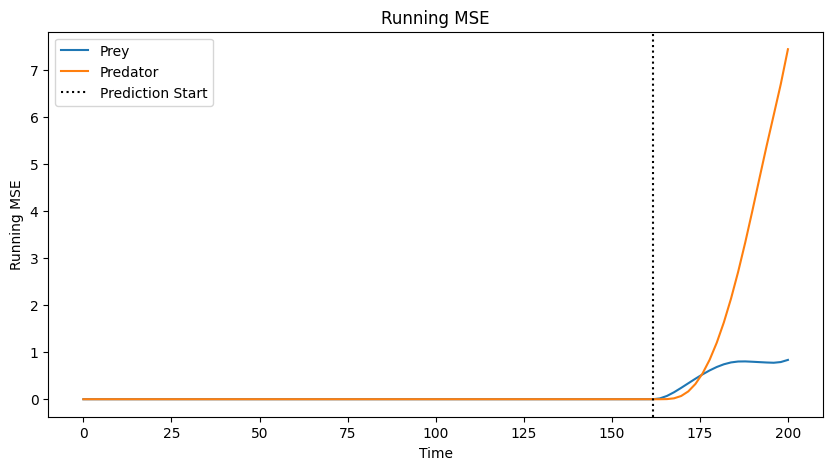

In [13]:
running_mse_prey = running_mse(pred_prey, actual_prey)
running_mse_predator = running_mse(pred_predator, actual_predator)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f"Running MSE")
ax.plot(full_times, running_mse_prey, label="Prey")
ax.plot(full_times, running_mse_predator, label="Predator")
ax.axvline(full_times[80], color="black", linestyle="dotted", label="Prediction Start")
ax.set_xlabel("Time")
ax.set_ylabel("Running MSE")
ax.legend()
plt.savefig(f"../plots/running_mse.png", dpi=300, bbox_inches="tight")
plt.show()